# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pyspark 
from pyspark import SparkConf 
from pyspark.sql import SparkSession

from pyspark.sql.functions import isnan, count, when, col, desc, udf, col 
from pyspark.sql.functions import sort_array, asc, avg
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import stddev as Fstddev
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler


from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

from pyspark.sql import Window

from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import rank 
import pyspark.sql.functions as F
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.sql.functions import first
from pyspark.sql.functions import lit

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split# Split the data into training and testing sets
from sklearn.ensemble import RandomForestClassifier as RandomForestClass


import pandas as pd 

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
! ls

mini_sparkify_event_data.json  Sparkify.ipynb  Sparkify-zh.ipynb


In [4]:
! ls -h -l 

total 123M
-rw-r--r-- 1 root root 123M Dec 15  2018 mini_sparkify_event_data.json
-rw-r--r-- 1 root root  70K Dec 24 20:43 Sparkify.ipynb
-rw-r--r-- 1 root root 4.8K Jul 31 09:13 Sparkify-zh.ipynb


In [5]:
path = "./mini_sparkify_event_data.json"
sparkify_event_data = spark.read.json(path)

Let's take a look at the first five records.

In [6]:
sparkify_event_data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

The above information is something hard to read that is why we will print the schema.

In [7]:
sparkify_event_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



We will add an ID column in order to have a primary key with the following code:

In [8]:
# good reference 
# https://towardsdatascience.com/adding-sequential-ids-to-a-spark-dataframe-fa0df5566ff6
window = Window.orderBy(F.col('userId'))

sparkify_event_data = sparkify_event_data.withColumn('id', F.row_number().over(window))

We can see the columns that we have in the dataset. We will show statistics for each column in the dataset with the following code.

In [9]:
sparkify_event_data.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+-----------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|               id|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+-----------------+
|  count|           228108|    286500|   278154|278154|            286500|  278154|            22810

The above information is difficult to read, we will take a look at individual columns.

In [10]:
sparkify_event_data.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



The above output is something strange because artist is string and the method describe is not enough smart to give us more useful information. Due to the variable is string we will show some values with the following code.

In [11]:
sparkify_event_data.select("artist").dropDuplicates().sort("artist").show(n=6)

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
+--------------------+
only showing top 6 rows



We will check how many rows we have in the dataframe.

In [12]:
sparkify_event_data.count()

286500

From the above, we conclude that the column artist has not a value for all of our records. This makes sense, since if the record does not refer to playing a song. We will show information about the other columns.

In [13]:
sparkify_event_data.select("auth").dropDuplicates().sort("auth").show()

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [14]:
sparkify_event_data.select("auth") \
     .groupBy("auth") \
     .agg({'auth' : 'count'}) \
     .withColumnRenamed('count(auth)', 'Authcount') \
     .sort(desc('Authcount')) \
     .show()

+----------+---------+
|      auth|Authcount|
+----------+---------+
| Logged In|   278102|
|Logged Out|     8249|
|     Guest|       97|
| Cancelled|       52|
+----------+---------+



The auth column refers to the current state of the session.

In [15]:
sparkify_event_data.select("firstName").dropDuplicates().sort("firstName").show(n=6)

+---------+
|firstName|
+---------+
|     null|
| Adelaida|
|   Adrian|
|  Adriana|
|   Adriel|
|  Ainsley|
+---------+
only showing top 6 rows



There are null values in the firstName column, it is possible that they are the [guest users](https://www.pcmag.com/encyclopedia/term/43999/guest-account). 

In [16]:
sparkify_event_data.select("gender").dropDuplicates().sort("gender").show()

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [17]:
sparkify_event_data.select("gender") \
     .groupBy("gender") \
     .agg({'gender' : 'count'}) \
     .withColumnRenamed('count(gender)', 'Gendercount') \
     .sort(desc('Gendercount')) \
     .show()

+------+-----------+
|gender|Gendercount|
+------+-----------+
|     F|     154578|
|     M|     123576|
|  null|          0|
+------+-----------+



There are zero null values in the gender column.

In [18]:
sparkify_event_data.describe("itemInSession").show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201140994|
|    min|                 0|
|    max|              1321|
+-------+------------------+



There are not missing values in the itemInSession variable. It seems that this variable referes to an internal code for the session in the browser. 

In [19]:
sparkify_event_data.select("lastname").dropDuplicates().sort("lastname").show(n=6)

+---------+
| lastname|
+---------+
|     null|
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
+---------+
only showing top 6 rows



There are null values in the lastname column, it is possible that they are the [guest users](https://www.pcmag.com/encyclopedia/term/43999/guest-account). 

In [20]:
sparkify_event_data.describe('length').show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



There are null values in the length variable.

In [21]:
sparkify_event_data.select(['auth', 'length', 'song']).where(sparkify_event_data["length"].isNull()).show(n=6)

+---------+------+----+
|     auth|length|song|
+---------+------+----+
|Logged In|  null|null|
|Logged In|  null|null|
|Logged In|  null|null|
|Logged In|  null|null|
|Logged In|  null|null|
|Logged In|  null|null|
+---------+------+----+
only showing top 6 rows



It seems that when the length is null also the song is null.

In [22]:
sparkify_event_data.select("length").dropDuplicates().sort("length").show()

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



This variable is the difference between the current and next value of ts (time stamp).

In [23]:
sparkify_event_data.select("level").dropDuplicates().sort("level").show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



The above variable reflects the type of subscription. 

In [24]:
sparkify_event_data.select("location").dropDuplicates().sort("location").show(n=6)

+--------------------+
|            location|
+--------------------+
|                null|
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
+--------------------+
only showing top 6 rows



It is possible that this variable is the location where the user is connected.

In [25]:
sparkify_event_data.select("method").dropDuplicates().sort("method").show()

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



This variable is related to the http protocol. The values of this variable are explicated below:

* GET: is used for retrieve data from a web server.
* PUT: is used to create or overwrite a resource at a particular URL that is known by the client. 

In [26]:
sparkify_event_data.select("page").dropDuplicates().sort("page").show(n=6)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
+--------------------+
only showing top 6 rows



This variable will be useful for generating the label or response variable.

In [27]:
sparkify_event_data.select("registration").dropDuplicates().sort("registration").show(n=6)

+-------------+
| registration|
+-------------+
|         null|
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
+-------------+
only showing top 6 rows



In [28]:
sparkify_event_data.select(['auth', 'length', 'song', 'registration']).where(sparkify_event_data["registration"].isNull()).show(n=6)

+----------+------+----+------------+
|      auth|length|song|registration|
+----------+------+----+------------+
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
|Logged Out|  null|null|        null|
+----------+------+----+------------+
only showing top 6 rows



It seems that this variable is some kind of identifier. In this variable there are null values and because of that it is possible that these nulls are associated with [guest users](https://www.pcmag.com/encyclopedia/term/43999/guest-account).

In [29]:
sparkify_event_data.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [30]:
sparkify_event_data.select("sessionId").dropDuplicates().sort("sessionId").show(n=6)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
+---------+
only showing top 6 rows



It seems that this variables is a kind of identifier for the session, there are no missinb values in this variable.

In [31]:
sparkify_event_data.select("song").dropDuplicates().sort("song").show(n=6)

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
+--------------------+
only showing top 6 rows



From the above, we conclude that the column artist has not a value for all of our records. This makes sense, since if the record does not refer to playing a song.

In [32]:
sparkify_event_data.select("status").dropDuplicates().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



The above refers to HTTP standard response code. 

* 404: Page not found 
* 200: OK 
* 307: Temporary redirect

In [33]:
sparkify_event_data.select("status") \
     .groupBy("status") \
     .agg({'status' : 'count'}) \
     .withColumnRenamed('count(status)', 'Statuscount') \
     .sort(desc('Statuscount')) \
     .show()

+------+-----------+
|status|Statuscount|
+------+-----------+
|   200|     259812|
|   307|      26430|
|   404|        258|
+------+-----------+



In [34]:
(258 / (258 + 259812 + 26430))*100

0.0900523560209424

In [35]:
sparkify_event_data.select("ts").dropDuplicates().sort("ts").show(n=6)

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
+-------------+
only showing top 6 rows



In [36]:
sparkify_event_data.describe("ts").show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810483...|
| stddev|1.5075439608226302E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



This variable is referred to the time stamp.

In [37]:
sparkify_event_data.select("UserAgent").dropDuplicates().sort("UserAgent").show()

+--------------------+
|           UserAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [38]:
sparkify_event_data.select(['auth', 'length', 'song', 'registration', 'UserAgent']).where(sparkify_event_data["UserAgent"].isNull()).show(n=6)

+----------+------+----+------------+---------+
|      auth|length|song|registration|UserAgent|
+----------+------+----+------------+---------+
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
|Logged Out|  null|null|        null|     null|
+----------+------+----+------------+---------+
only showing top 6 rows



This variables is refered to the web browser.

In [39]:
sparkify_event_data.select("userId").dropDuplicates().sort("userId").show(n=6)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 6 rows



This variable is the user id. There are null values that because of that it is possible that these nulls are associated with [guest users](https://www.pcmag.com/encyclopedia/term/43999/guest-account).

In [40]:
sparkify_event_data.select("userId").dropDuplicates().count()

226

There are 226 users.

In [41]:
sparkify_event_data.select(["userId", "level"]) \
      .filter(sparkify_event_data["level"] == "paid") \
      .select("userId") \
      .dropDuplicates() \
      .count()

166

There are 166 paid users.

In [42]:
sparkify_event_data.select(["userId", "level"]) \
      .filter(sparkify_event_data["level"] == "free") \
      .select("userId") \
      .dropDuplicates() \
      .count()

196

There are 196 users.

In [43]:
sparkify_event_data.select(["level"]) \
     .groupBy("level") \
     .agg({'level' : 'count'}) \
     .withColumnRenamed('count(level)', 'Levelcount') \
     .sort(desc('Levelcount')) \
     .show()

+-----+----------+
|level|Levelcount|
+-----+----------+
| paid|    228162|
| free|     58338|
+-----+----------+



The above table shows the usage of the sparkify app between paid and free users. It seems that paid users are using the app more often than free users. We will verify if there are users who have paid and free plan at some time.

In [44]:
# good reference 
# https://stackoverflow.com/questions/44168379/how-to-check-for-intersection-of-two-dataframe-columns-in-spark

sparkify_event_data.filter(sparkify_event_data["level"] == "paid") \
      .select("userId").dropDuplicates() \
      .intersect(sparkify_event_data.filter(sparkify_event_data["level"] == "free") \
      .select("userId").dropDuplicates() \
      ).count()

136

There are 136 users who have paid and free plan at some time.

We will get the events associated with the user with id equals to 100001.

In [45]:
sparkify_event_data.select(['page', 'userId', 'auth', 'status', 'song']).where(sparkify_event_data.userId == '100001').collect()

[Row(page='Home', userId='100001', auth='Logged In', status=200, song=None),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song='Just Dance'),
 Row(page='Roll Advert', userId='100001', auth='Logged In', status=200, song=None),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song='Kids With Guns (Quiet Village Remix)'),
 Row(page='Roll Advert', userId='100001', auth='Logged In', status=200, song=None),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song="Do You Think I'm Spooky?"),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song="Can't Hardly Wait (Remastered Version)"),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song='Propane Nightmares'),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song='Falling'),
 Row(page='NextSong', userId='100001', auth='Logged In', status=200, song='Runaway'),
 Row(page='NextSong', userId='100001', auth='Logged In', statu

The user with id equals to 100001 has listened to a few songs. 

We will remove the missing values. From the previous comments there are no missing values in userId nor sessionId, however we will remove observations according to the following criteria: 

* Auth variable is equals to Guest. 


In [46]:
sparkify_event_data = sparkify_event_data.filter(sparkify_event_data["auth"] != "Guest")

In [47]:
sparkify_event_data.count()

286403

We have removed 286500 - 286403 = 97 observations.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In order to define the churn variable we will do some exploration. 

In [48]:
flag_churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [49]:
sparkify_event_data = sparkify_event_data.withColumn("churn", flag_churn_event("page"))

We have created the churn column that has the value 1 if the user has cancelled the service, 0 otherwise. We will explore how many times the users have cancelled the service. 

In [50]:
user_agg_churn = sparkify_event_data.select(["userId", "churn"]) \
     .groupBy("userId") \
     .agg(Fsum('churn').alias('sum'))

In [51]:
user_agg_churn.filter(user_agg_churn["sum"] == 0).count()

174

There are 174 users that have not cancelled the service.

In [52]:
user_agg_churn.filter(user_agg_churn["sum"] == 1).count()

52

There are 52 users that have cancelled the service.

In [53]:
user_agg_churn.filter(user_agg_churn["sum"] > 1).count()

0

There are no users that have cancelled the service more than 1 time, it means that there are no users that they returned back to the previous type of service (free or paid).

We will find users that had cancelled the service and after that they returned to the service. In order to find these users we will use window functions. 

In [54]:
churned_users = sparkify_event_data.filter(sparkify_event_data["churn"] == 1)
churned_users = churned_users.select("userId").dropDuplicates()
churned_users = churned_users.join(sparkify_event_data, on=['userId'], how="inner") 
churned_users = churned_users.select("userId", "ts", "churn")
windowval = Window.partitionBy("userId").orderBy(desc("ts"))
u = churned_users.select("userId", "ts", "churn", rank().over(windowval).alias("ranking"))

In [55]:
(u.filter(u["ranking"] == 1)).filter(u["churn"] == 0).show()

+------+-------------+-----+-------+
|userId|           ts|churn|ranking|
+------+-------------+-----+-------+
|   125|1539318918000|    0|      1|
+------+-------------+-----+-------+



In [56]:
sparkify_event_data.filter(sparkify_event_data["userId"] == 125).select(["id", "userId", "ts", "churn", "page"]).show(n=11)

+-----+------+-------------+-----+--------------------+
|   id|userId|           ts|churn|                page|
+-----+------+-------------+-----+--------------------+
|54661|   125|1539317144000|    0|            NextSong|
|54662|   125|1539317481000|    0|            NextSong|
|54663|   125|1539317711000|    0|            NextSong|
|54664|   125|1539317914000|    0|            NextSong|
|54665|   125|1539318124000|    0|            NextSong|
|54666|   125|1539318515000|    0|            NextSong|
|54667|   125|1539318728000|    0|            NextSong|
|54668|   125|1539318906000|    0|            NextSong|
|54669|   125|1539318917000|    0|         Roll Advert|
|54670|   125|1539318918000|    0|              Cancel|
|54671|   125|1539318918000|    1|Cancellation Conf...|
+-----+------+-------------+-----+--------------------+



It seems that the two last rows have the same value in the ts column, I think this value is a kind of error, it is impossible for a human to do this that is why we will the row with the id = 54670.

In [57]:
sparkify_event_data = sparkify_event_data.filter(sparkify_event_data["id"] != 54670)

In order to create the data that will be used by the machine learning model, we will generate the following information for each user: 

* median, min, max, standard deviation of the length variable 
* gender 
* level 
* method 
* status 

We will incorporate the information of the length variable.

In [58]:
# good reference
# https://stackoverflow.com/questions/46845672/median-quantiles-within-pyspark-groupby

median_fun = F.expr('percentile_approx(length, 0.5)')

length_data = sparkify_event_data.select(["userId", "length"]) \
                 .filter(sparkify_event_data.length.isNotNull()) \
                 .groupBy("userId") \
                 .agg(median_fun.alias("median_length"), \
                      Fmin("length").alias("min_length"), 
                      Fmax("length").alias("max_length"), 
                      Fstddev("length").alias("stddev_length"))

In [59]:
length_data.select("median_length").summary().show()

+-------+------------------+
|summary|     median_length|
+-------+------------------+
|  count|               225|
|   mean|234.23559915555558|
| stddev| 4.051835569971286|
|    min|         213.60281|
|    25%|         232.61995|
|    50%|          234.1873|
|    75%|         236.09424|
|    max|         248.63302|
+-------+------------------+



We will incorporate the information of the page variable.

In [60]:
page_data = sparkify_event_data.select(["userId", "page"]) \
                  .groupBy(["userId", "page"]) \
                  .agg({'page' : 'count'}) \
                  .withColumnRenamed('count(page)', 'count')


# good reference 
# https://stackoverflow.com/questions/37486910/pivot-string-column-on-pyspark-dataframe
# https://databricks.com/blog/2016/02/09/reshaping-data-with-pivot-in-apache-spark.html

page_data = page_data.select(["userId", "page", "count"]) \
            .groupby("userId") \
            .pivot("page") \
            .agg(first("count")) 


page_data = page_data.fillna(0)

In [61]:
page_data.select("Add Friend").summary().show()

+-------+------------------+
|summary|        Add Friend|
+-------+------------------+
|  count|               226|
|   mean|18.924778761061948|
| stddev|20.574819695598574|
|    min|                 0|
|    25%|                 4|
|    50%|                13|
|    75%|                27|
|    max|               143|
+-------+------------------+



We will incorporate the information of the level variable.

In [62]:
level_data = sparkify_event_data.select(["userId", "level"]) \
                  .groupBy(["userId", "level"]) \
                  .agg({'level' : 'count'}) \
                  .withColumnRenamed('count(level)', 'count')


level_data = level_data.select(["userId", "level", "count"]) \
            .groupby("userId") \
            .pivot("level") \
            .agg(first("count")) 

level_data = level_data.fillna(0)

In [63]:
level_data.select("paid", "free").summary().show()

+-------+------------------+------------------+
|summary|              paid|              free|
+-------+------------------+------------------+
|  count|               226|               226|
|   mean| 1009.566371681416| 257.6991150442478|
| stddev|1275.4176788704242|336.55446011223137|
|    min|                 0|                 0|
|    25%|                 0|                40|
|    50%|               541|               152|
|    75%|              1672|               345|
|    max|              7779|              2520|
+-------+------------------+------------------+



We will incorporate the information of the status variable.

In [64]:
status_data = sparkify_event_data.select(["userId", "status"]) \
                  .groupBy(["userId", "status"]) \
                  .agg({'status' : 'count'}) \
                  .withColumnRenamed('count(status)', 'count')

status_data = status_data.select(["userId", "status", "count"]) \
            .groupby("userId") \
            .pivot("status") \
            .agg(first("count")) 

status_data = status_data.fillna(0)

We will rename the columns in a convenient way, for example it is better to have x200 than  200.

In [65]:
# good resource 
# https://stackoverflow.com/questions/38798567/pyspark-rename-more-than-one-column-using-withcolumnrenamed/48095327

def rename_columns(df, columns):
    
    """ Returns a PySpark dataframe with the name of columns changed. 
    
    Parameters:
        df (PySpark dataframe): the PySpark dataframe.  
        columns (dictionary): a dictionary with the name of columns to be changed.
        
    Returns: a PySpark with the name of the columns changed.
    """    
    
    
    if isinstance(columns, dict):
        for old_name, new_name in columns.items():
            df = df.withColumnRenamed(old_name, new_name)
        return df
    else:
        raise ValueError("'columns' should be a dict, like {'old_name_1':'new_name_1', 'old_name_2':'new_name_2'}")

In [66]:
status_data = rename_columns(status_data, {'200' : 'x200', '307' : 'x307', '404' : 'x404'})

In [67]:
status_data.select("x200", "x307", "x404").summary().show()

+-------+------------------+------------------+------------------+
|summary|              x200|              x307|              x404|
+-------+------------------+------------------+------------------+
|  count|               226|               226|               226|
|   mean|1149.2079646017698|116.92035398230088|1.1371681415929205|
| stddev|1243.7113942205647| 236.4799692374405|1.4918263044717583|
|    min|                 6|                 0|                 0|
|    25%|               267|                25|                 0|
|    50%|               771|                70|                 1|
|    75%|              1725|               147|                 2|
|    max|              8909|              3241|                 7|
+-------+------------------+------------------+------------------+



We will incorporate the information of the gender.

In [68]:
gender_data = sparkify_event_data.select(["userId", "gender"]).distinct()

In [69]:
gender_data.select("gender") \
     .groupBy("gender") \
     .agg({'gender' : 'count'}) \
     .withColumnRenamed('count(gender)', 'Gendercount') \
     .show()

+------+-----------+
|gender|Gendercount|
+------+-----------+
|     M|        121|
|     F|        104|
|  null|          0|
+------+-----------+



We will create a variable called label_data that will contain the information of the users who have canceled the service and those who not.

In [70]:
churned_users = sparkify_event_data.select(["userId", "churn"]) \
                      .filter(sparkify_event_data["churn"] == 1)

In [71]:
# good reference
# https://stackoverflow.com/questions/32788322/how-to-add-a-constant-column-in-a-spark-dataframe
# we remove churned users from active users.

active_users = sparkify_event_data.filter(sparkify_event_data["churn"] == 0) \
                    .select("userId").subtract(churned_users.select("userId"))

In [72]:
active_users = active_users.withColumn('churn', lit(0))

In [73]:
# good reference 
# https://stackoverflow.com/questions/37332434/concatenate-two-pyspark-dataframes
label_data = active_users.union(churned_users)

Finally, we will join the information of the following pyspark dataframes: label_data, length_data, page_data, level_data, and status_data.

In [74]:
processed_data = label_data.join(gender_data, on=['userId'], how="inner")

processed_data = processed_data.join(length_data, on=['userId'], how='inner')

processed_data = processed_data.join(page_data, on=['userId'], how='inner') 

processed_data = processed_data.join(level_data, on=['userId'], how='inner') 

processed_data = processed_data.join(status_data, on=['userId'], how='inner') 

The user id column is no longer useful that is why we will drop this varible with the following code:

In [75]:
# good reference
# https://stackoverflow.com/questions/29600673/how-to-delete-columns-in-pyspark-dataframe

drop_list = ['userId']
processed_data = processed_data.select( \
     [column for column in processed_data.columns if column not in drop_list])

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

We will convert the data processed to Pandas with the following code.

In [76]:
processed_data_pd = processed_data.toPandas()

In [77]:
churn_count = processed_data_pd["churn"].value_counts()

In [78]:
churn_count.index = ["active users", "churned users"]

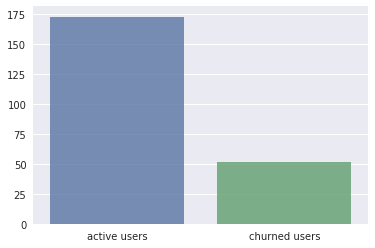

In [79]:
sns.barplot(churn_count.index, churn_count.values, alpha=0.8)

There are more active users than churned users, this kind of pattern is known in the literature as the [imbalanced dataset problem](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/).

Gender vs Churn

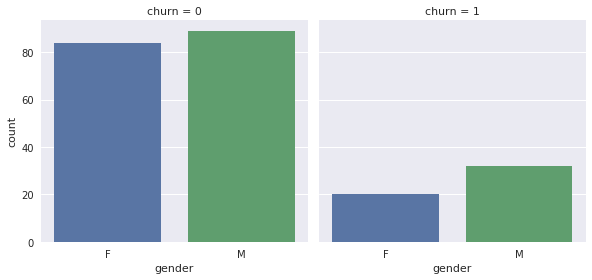

In [80]:
sns.factorplot("gender", col = "churn", col_wrap = 3, \
               data = processed_data_pd, kind = "count")
plt.show()

median_length vs churn

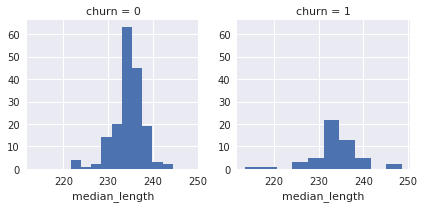

In [81]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "median_length")

min_length vs churn 

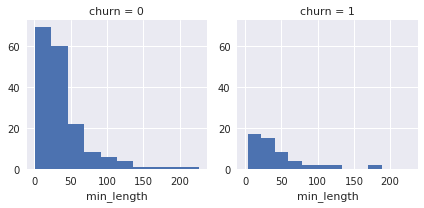

In [82]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "min_length")

max_length vs churn 

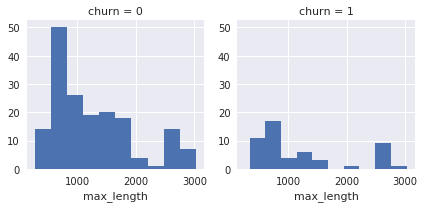

In [83]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "max_length")

stddev_length vs churn 

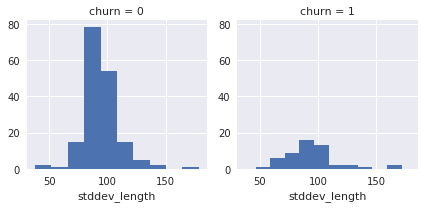

In [84]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "stddev_length")

About vs churn 

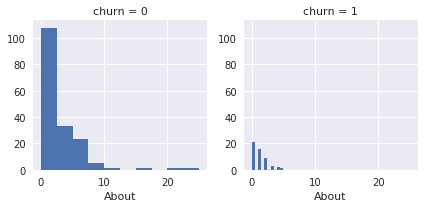

In [85]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "About")

Add Friend vs churn 

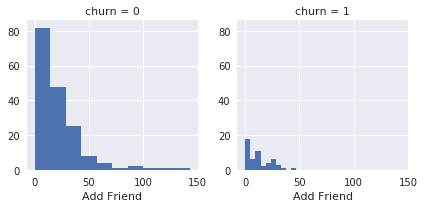

In [86]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Add Friend")

Add to Playlist vs churn

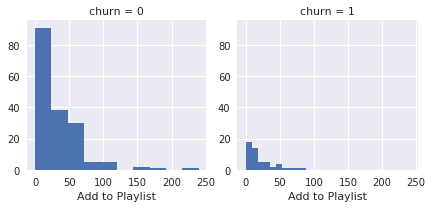

In [87]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Add to Playlist")

'Cancel' vs churn

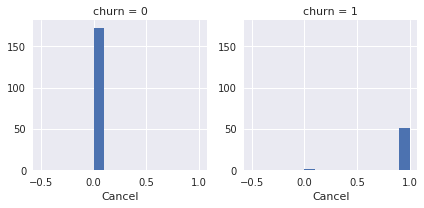

In [88]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Cancel")

We have to exclude the variable Cancel because it will produce a [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/). 

Cancellation Confirmation vs churn 

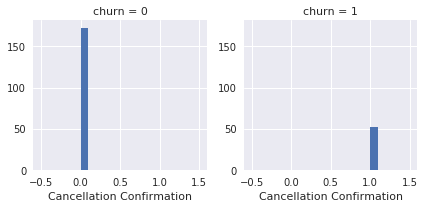

In [89]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Cancellation Confirmation")

We have to exclude the variable Cancel Confirmation because it will produce a [data leakage](https://machinelearningmastery.com/data-leakage-machine-learning/). 

Downgrade vs churn

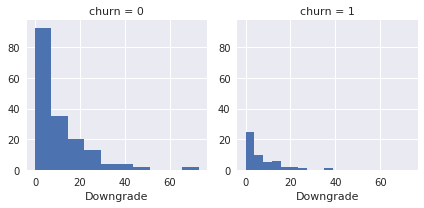

In [90]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, 'Downgrade')

Error vs churn.

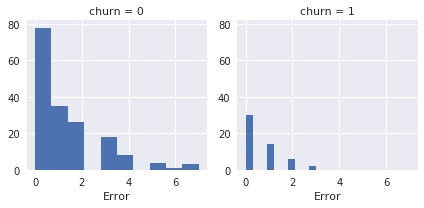

In [91]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, 'Error')

Help vs churn

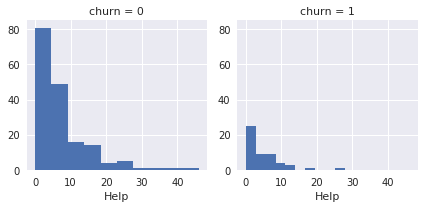

In [92]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, 'Help')

Home vs churn 

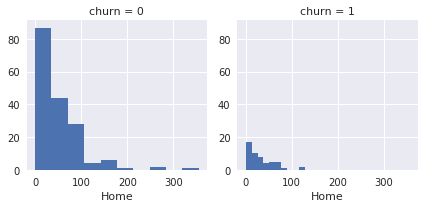

In [93]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, 'Home')

Login vs churn

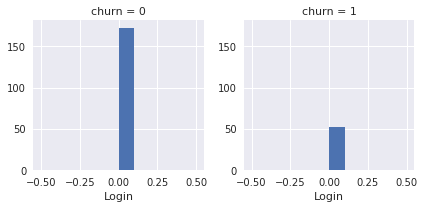

In [94]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, 'Login')

In [95]:
processed_data_pd["Login"].unique()

array([0])

We will exclude the Login variable because there is no variability in this variable.

Logout vs churn

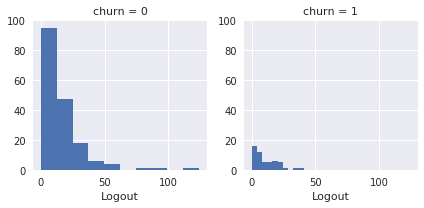

In [96]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, 'Logout')

NextSong vs churn

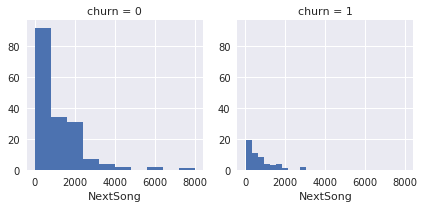

In [97]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "NextSong")


Roll Advert vs churn

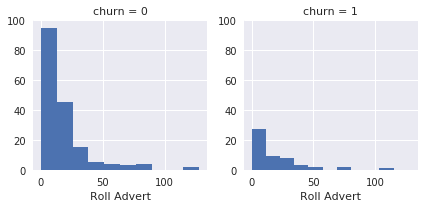

In [98]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Roll Advert")


Save Settings vs churn

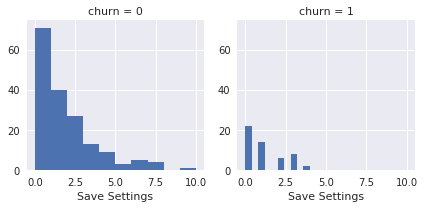

In [99]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Save Settings")


Submit Downgrade vs churn

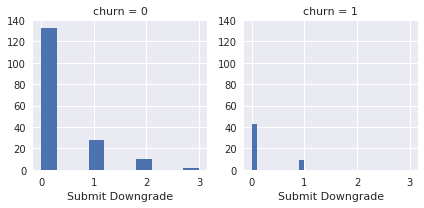

In [100]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Submit Downgrade")


Submit Upgrade vs churn

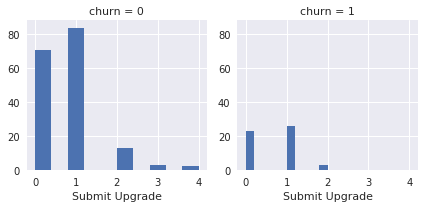

In [101]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Submit Upgrade")


Thumbs Down vs churn

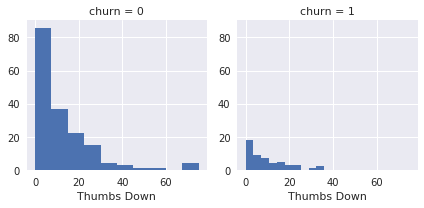

In [102]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Thumbs Down")


Thumbs Up vs churn 

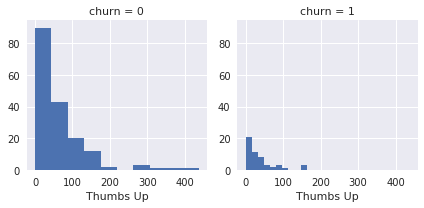

In [103]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Thumbs Up")


Upgrade vs churn

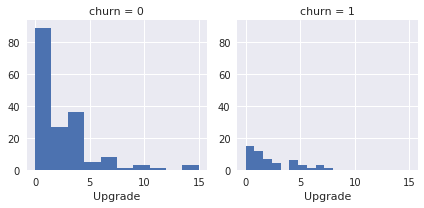

In [104]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "Upgrade")


Free users vs churn

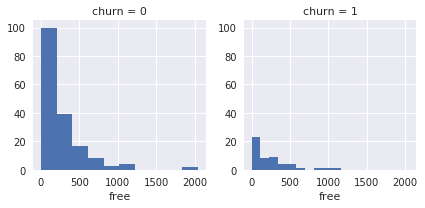

In [105]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "free")


Paid users vs churn

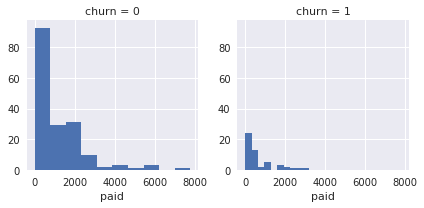

In [106]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "paid")


Http Status Code = 200 (OK)  vs churn

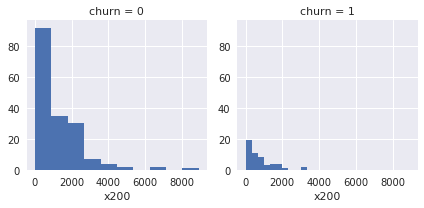

In [107]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "x200")


Http Status Code = 404 (Page not found) vs churn

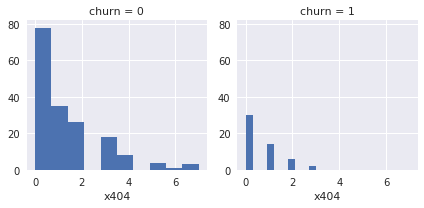

In [108]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "x404")


Http status code = 307 (Temporary Redirect) vs churn

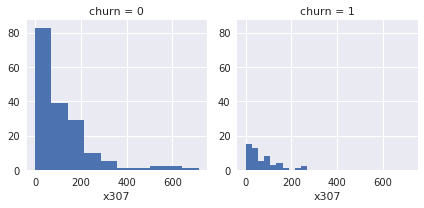

In [109]:
g = sns.FacetGrid(processed_data_pd, col="churn")
g = g.map(plt.hist, "x307")


From the above we will exclude the following variables: Cancel, Cancellation Confirmation, and Login. Most of the other variables have little correlation with the output variable (churn) since that the distribution of these variables keep right skewed   in each level of the output variable (1 = churned user, 0 = active users). We will build a scatter plot matrix between each pair of numeric predictors.

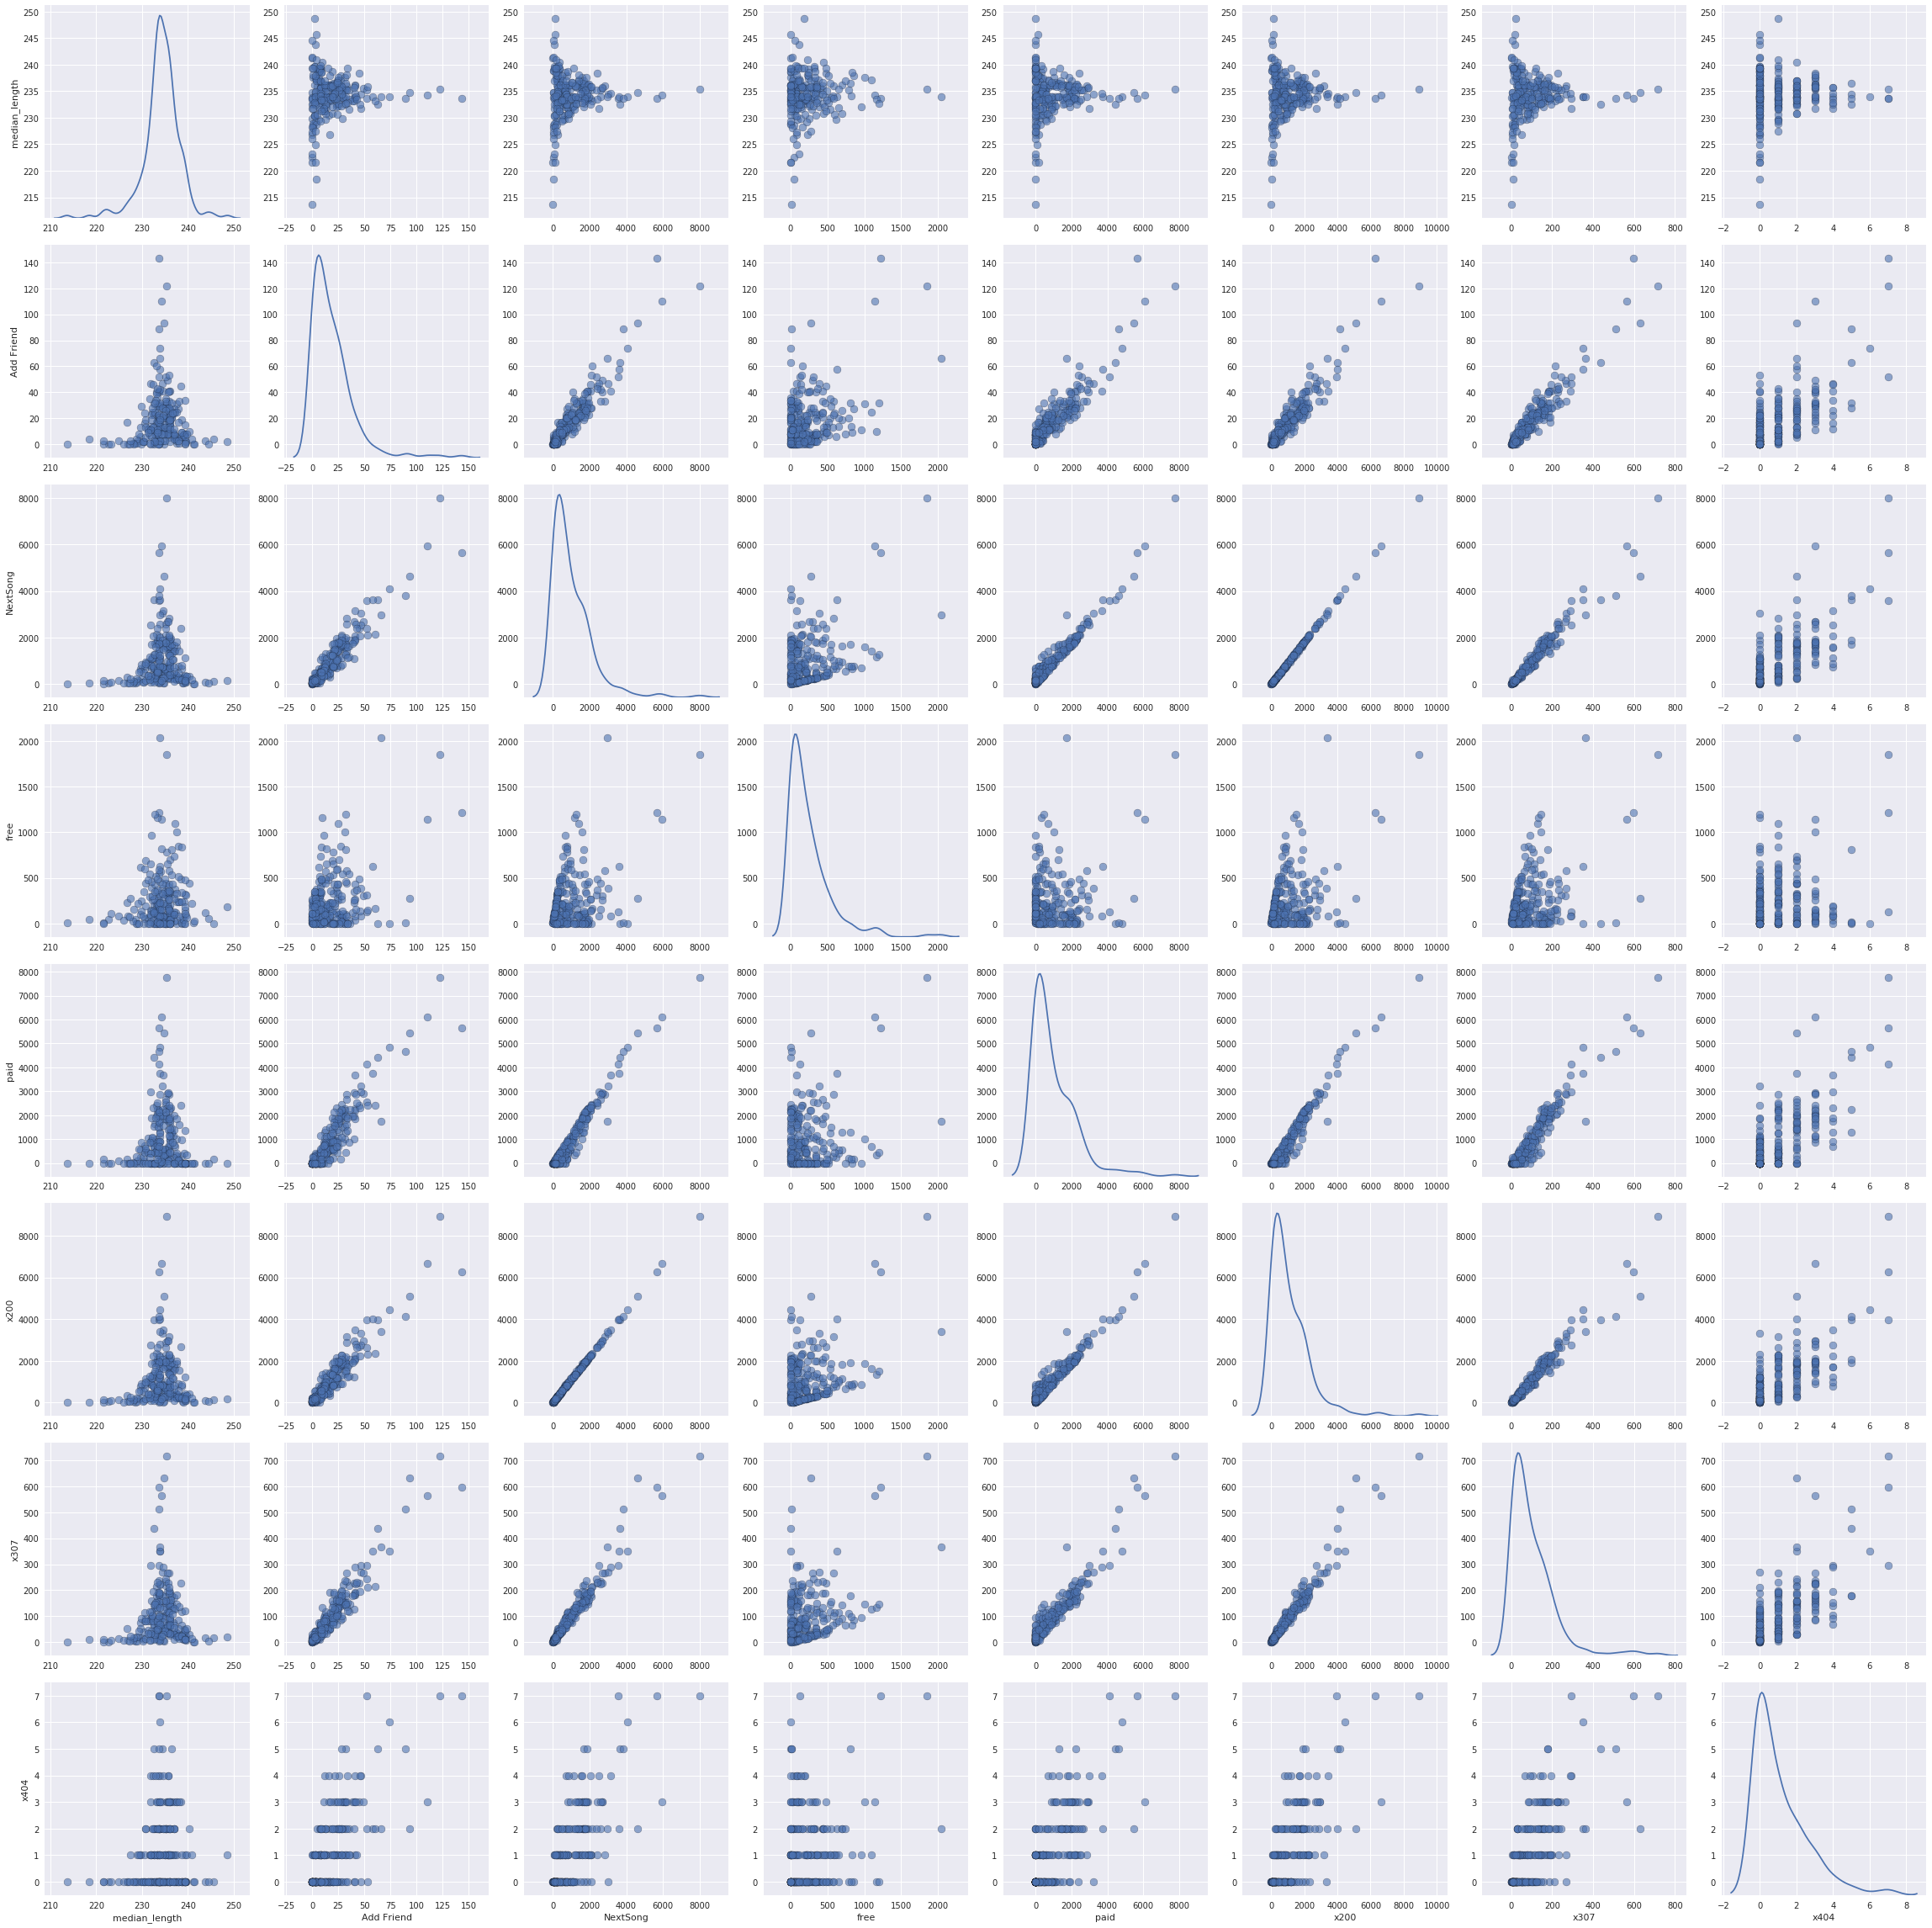

In [110]:
selected_predictors = ['median_length', 'Add Friend', 'NextSong', 'free', 'paid', 'x200', 'x307', 'x404'               
]
sns.pairplot(processed_data_pd[selected_predictors], diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
             size = 4)

We will use a random forest model in order to detect which user is prone to churn the service.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [111]:
drop_list = ['Cancel', 'Cancellation Confirmation', 'Login' ]
processed_data = processed_data.select( \
     [column for column in processed_data.columns if column not in drop_list])

The classification problem is imbalanced that is why we will use stratified sampling in order to balanced the classes.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**Note**: I used the following resource as a guide.

https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa

### Preparing Data for Machine Learning 

We will use stratified sampling in order to treat the imbalanced classification problem, the following resource was useful:
https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/

In [112]:
processed_data.select('churn') \
     .groupBy("churn") \
     .agg({'churn' : 'count'}) \
     .withColumnRenamed('count(churn)', 'Churncount') \
     .show()

+-----+----------+
|churn|Churncount|
+-----+----------+
|    1|        52|
|    0|       173|
+-----+----------+



In [113]:
processed_data = processed_data.sampleBy('churn', fractions={0: 52/225, 1: 1.0}).cache()

In [114]:
processed_data.select('churn') \
     .groupBy("churn") \
     .agg({'churn' : 'count'}) \
     .withColumnRenamed('count(churn)', 'Churncount') \
     .show()

+-----+----------+
|churn|Churncount|
+-----+----------+
|    1|        52|
|    0|        38|
+-----+----------+



In [115]:
processed_data_pd = processed_data.toPandas() # We will use this pandas dataframe later

In order to treat the numeric and categorical variables in a proper way, we will do the following operations:

In [116]:
cols = processed_data.columns

categoricalColumns = ['gender']

stages = [] 


for categoricalCol in categoricalColumns:    
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]    

In [117]:
label_stringIdx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_stringIdx]

In [118]:
numericCols = [ 'median_length', 'min_length', 'max_length', 
                'stddev_length','About', 'Add Friend','Add to Playlist',
                'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong',
                'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade',
                'Submit Upgrade', 'Thumbs Down','Thumbs Up', 'Upgrade','free',
                'paid', 'x200','x307', 'x404']

assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]



### Base line model
We use a random forest with default values as our base line model in order to make comparison with other models.

In [119]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=123)

stages += [rf]

We will show the parameters of the baseline model, the following resource was useful:

https://stackoverflow.com/questions/42549200/how-to-get-all-parameters-of-estimator-in-pyspark

In [120]:
{param[0].name: param[1] for param in rf.extractParamMap().items()}

{'probabilityCol': 'probability',
 'rawPredictionCol': 'rawPrediction',
 'seed': 123,
 'predictionCol': 'prediction',
 'labelCol': 'label',
 'featuresCol': 'features',
 'maxDepth': 5,
 'maxBins': 32,
 'minInstancesPerNode': 1,
 'minInfoGain': 0.0,
 'maxMemoryInMB': 256,
 'cacheNodeIds': False,
 'checkpointInterval': 10,
 'impurity': 'gini',
 'numTrees': 20,
 'featureSubsetStrategy': 'auto',
 'subsamplingRate': 1.0}

### Pipeline

We build the pipelines for random forest model as follows.

In [121]:
pipeline = Pipeline(stages=stages) 

### Train Test split 

Due to the small size of the data we will use cross validation as a mean of comparison between the models that will be proposed that is why we don't use a validation dataset. The test dataset is used to provide us an unbiased evaluation of the final model.

In [122]:
train, test = processed_data.randomSplit([0.9, 0.1], seed=123)

### Tune model 

In [123]:
# we fix the parameters of the base line model. 
# the following web site was a good reference:
# https://stackoverflow.com/questions/52740966/how-to-perform-cross-validation-without-using-paramgrid-builder-in-pyspark

paramGrid = ParamGridBuilder() \
    .addGrid(rf.probabilityCol,['probability']) \
    .addGrid(rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(rf.seed,[123]) \
    .addGrid(rf.predictionCol,['prediction']) \
    .addGrid(rf.labelCol,['label']) \
    .addGrid(rf.featuresCol,['features']) \
    .addGrid(rf.maxDepth,[5]) \
    .addGrid(rf.maxBins,[32]) \
    .addGrid(rf.minInstancesPerNode,[1]) \
    .addGrid(rf.minInfoGain,[0.0]) \
    .addGrid(rf.maxMemoryInMB,[256]) \
    .addGrid(rf.checkpointInterval,[10]) \
    .addGrid(rf.impurity,['gini']) \
    .addGrid(rf.numTrees,[20]) \
    .addGrid(rf.featureSubsetStrategy,['auto']) \
    .addGrid(rf.subsamplingRate,[1.0]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

In [124]:
cvModel_m1 = crossval.fit(train)

In [125]:
cvModel_m1.avgMetrics

[0.673611111111111]

Due to we fixed the random forest model (we don't use a grid search) we get the average 
of the accuracy in three folds of the proposed random forest model.

### Evaluating the random forest model in the training set

In [126]:
# accuracy in the training dataset
predictions = cvModel_m1.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the training dataset = %g" % (acc))

Accuracy in the training dataset = 0.9875


The random forest model works well in the training dataset with an accuracy of 0.98 accuracy but its performace is of 0.67 (average) in three folds. This is a case of overfitting and because of that we will select the best predictors using feature importance. 

## Removing predictors

We will explore removing some unnecessary predictors using feature importance. The following resource was useful:

https://www.timlrx.com/2018/06/19/feature-selection-using-feature-importance-score-creating-a-pyspark-estimator/

In [127]:
cvModel_m1.bestModel.stages[-1].featureImportances

SparseVector(27, {0: 0.0038, 1: 0.0648, 2: 0.0275, 3: 0.0198, 4: 0.056, 5: 0.0092, 6: 0.1317, 7: 0.028, 8: 0.0157, 9: 0.026, 10: 0.0397, 11: 0.0579, 12: 0.0484, 13: 0.0161, 14: 0.0314, 15: 0.0286, 16: 0.0438, 17: 0.0041, 18: 0.0126, 19: 0.0645, 20: 0.0855, 21: 0.014, 22: 0.0304, 23: 0.0297, 24: 0.0214, 25: 0.0371, 26: 0.0524})

The feature importance vector is returned as a sparse vector. This format is not convenient for a human that is why we use the following function.

In [128]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    
    """ Returns a list of feature importances from a Random Forest model. 
    
    Parameters:
        featureImp (SparseVector): the feature importance.  
        dataset (pandas dataframe): the dataset as a pandas dataframe.
        featureCol (string): parameter related to the schema of the dataset variable.
        
        
    Returns: a dataframe with the feature importances from a random forest model
    """    
    
    
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [129]:
pipeline_model = pipeline.fit(train)

In [130]:
df = pipeline_model.transform(train)

In [131]:
ExtractFeatureImp(cvModel_m1.bestModel.stages[-1].featureImportances, \
                  df, "features").head(27)

,idx,name,score
5,6,Add Friend,0.131654
19,20,Thumbs Up,0.085466
0,1,median_length,0.064822
18,19,Thumbs Down,0.064451
10,11,Home,0.057941
3,4,stddev_length,0.056029
25,26,x404,0.052378
11,12,Logout,0.048363
15,16,Settings,0.043823
9,10,Help,0.039687


We will exclude variables with a value of importance below to 0.03, which are: About, Help, Upgrade, Home, gender, Thumbs Up, x200, Error, Submit Upgrade, x404, and Submit Downgrade. Next, we will recreate the random forest model without these predictors.

In [132]:
stages = [] 


label_stringIdx = StringIndexer(inputCol = 'churn', outputCol = 'label')
stages += [label_stringIdx]

numericCols = [ 'median_length', 'min_length', 'max_length', 
                'stddev_length', 'Add Friend','Add to Playlist',
                'Downgrade', 'Logout', 'NextSong',
                'Roll Advert', 'Save Settings', 'Settings',
                'Thumbs Down','free',
                'paid','x307']



assemblerInputs = numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=123)

stages += [rf]

In [133]:
pipeline = Pipeline(stages=stages) 

In [134]:
# we fix the parameters of the base line model. 
# the following web site was a good reference:
# https://stackoverflow.com/questions/52740966/how-to-perform-cross-validation-without-using-paramgrid-builder-in-pyspark

paramGrid = ParamGridBuilder() \
    .addGrid(rf.probabilityCol,['probability']) \
    .addGrid(rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(rf.seed,[123]) \
    .addGrid(rf.predictionCol,['prediction']) \
    .addGrid(rf.labelCol,['label']) \
    .addGrid(rf.featuresCol,['features']) \
    .addGrid(rf.maxDepth,[5]) \
    .addGrid(rf.maxBins,[32]) \
    .addGrid(rf.minInstancesPerNode,[1]) \
    .addGrid(rf.minInfoGain,[0.0]) \
    .addGrid(rf.maxMemoryInMB,[256]) \
    .addGrid(rf.checkpointInterval,[10]) \
    .addGrid(rf.impurity,['gini']) \
    .addGrid(rf.numTrees,[20]) \
    .addGrid(rf.featureSubsetStrategy,['auto']) \
    .addGrid(rf.subsamplingRate,[1.0]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

In [135]:
cvModel_m2 = crossval.fit(train)

In [136]:
cvModel_m2.avgMetrics

[0.5844907407407408]

### Evaluating the random forest model in the training dataset

In [137]:
# accuracy in the training dataset
predictions = cvModel_m2.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the training dataset = %g" % (acc))

Accuracy in the training dataset = 0.9875


This model also exhibits overfitting 0.98 of accuracy in the training and 0.58 of accuracy in the cross validation set.

## Varying the maxDepth in order to treat overfitting

The maxDepth controls the complexity of a random forest model, since that our previous random forest model still exhibits overfitting we will vary the maxDepth from 1 to 5.  

In [138]:
# we fix the parameters of the base line model. 
# the following web site was a good reference:
# https://stackoverflow.com/questions/52740966/how-to-perform-cross-validation-without-using-paramgrid-builder-in-pyspark

paramGrid = ParamGridBuilder() \
    .addGrid(rf.probabilityCol,['probability']) \
    .addGrid(rf.rawPredictionCol,['rawPrediction']) \
    .addGrid(rf.seed,[123]) \
    .addGrid(rf.predictionCol,['prediction']) \
    .addGrid(rf.labelCol,['label']) \
    .addGrid(rf.featuresCol,['features']) \
    .addGrid(rf.maxDepth,[1,2,3,4,5]) \
    .addGrid(rf.maxBins,[32]) \
    .addGrid(rf.minInstancesPerNode,[1]) \
    .addGrid(rf.minInfoGain,[0.0]) \
    .addGrid(rf.maxMemoryInMB,[256]) \
    .addGrid(rf.checkpointInterval,[10]) \
    .addGrid(rf.impurity,['gini']) \
    .addGrid(rf.numTrees,[20]) \
    .addGrid(rf.featureSubsetStrategy,['auto']) \
    .addGrid(rf.subsamplingRate,[1.0]) \
    .build()


crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(metricName="accuracy"),
                          numFolds=3)

In [139]:
cvModel_m3 = crossval.fit(train)

In [140]:
cvModel_m3.avgMetrics

[0.652281746031746,
 0.5650903880070547,
 0.5492173721340389,
 0.5461860670194004,
 0.5844907407407408]

We will get the parameters of the best model using the previous grid:

In [144]:
# good reference 
# https://forums.databricks.com/questions/12097/pyspark-how-to-get-best-params-in-grid-search.html

list(zip(cvModel_m3.avgMetrics, paramGrid))[0]

(0.652281746031746,
 {Param(parent='RandomForestClassifier_663c9d5efb36', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities.'): 'probability',
  Param(parent='RandomForestClassifier_663c9d5efb36', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
  Param(parent='RandomForestClassifier_663c9d5efb36', name='seed', doc='random seed.'): 123,
  Param(parent='RandomForestClassifier_663c9d5efb36', name='predictionCol', doc='prediction column name.'): 'prediction',
  Param(parent='RandomForestClassifier_663c9d5efb36', name='labelCol', doc='label column name.'): 'label',
  Param(parent='RandomForestClassifier_663c9d5efb36', name='featuresCol', doc='features column name.'): 'features',
  Param(parent='RandomForestClassifier_663c9d5efb36', name='maxDepth', doc='Maximum

With a maxDepth equal to 1, we get an average of 0.65 in the tree folds.

### Evaluating the random forest model in the training dataset

In [142]:
# accuracy in the training dataset
predictions = cvModel_m3.transform(train)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the training dataset = %g" % (acc))

Accuracy in the training dataset = 0.7375


### Evaluating the random forest model in the test dataset

In [143]:
# accuracy in the training dataset
predictions = cvModel_m3.transform(test)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc = evaluator.evaluate(predictions)
print("Accuracy in the test dataset = %g" % (acc))

Accuracy in the test dataset = 0.6


We choose as the best model the model with a maxDepth equals to 1 that uses a reduced set of predictors. In spite of the first model that has an accuracy of 0.67 which is greater than the model with a maxDepth equals to 1, it is preferable the model with a maxDepth equals to 1 due to the following reasons: 

* It has fewer parameters and because of that it is less prone to overfitting.
* The accuracy in the training data set is similar to the average of accuracies in the tree folds and because of that this model does not suffer from severe overfitting.

**Note**: There are some problems of reproducibility with the results, I tried to be careful setting every random seed but the results change with each execution, is it possible that the reason for that is the distribuded behaviour of Apache Spark?

# Conclusions

* The best model has an accuracy of 0.55 little better than 0.5. 
* Due to computational limitations we do not add more parameters to the grid in the CrossValidator.
* It is possible to improve the model using a more sophisticated model such as gradient boosting or deep learning.
* If we get more data we can estimate a more accurate model and it is possible to get a better performance.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.